In [2]:
import pandas as pd

data = pd.read_csv('data/dataframe_final.csv', index_col=0)
label = pd.read_csv('data/label_final.csv', index_col=0)
data_std = pd.read_csv('data/dataframe_std.csv', index_col=0)

In [3]:
import numpy as np
from datetime import datetime

def create_sequences(s_year, dataframe, label):
    Xs, ys = [], []
    curday = datetime(s_year, 1, 1)
    dayformat = curday.strftime('%Y-%m-%d')
    for idx in dataframe.index:
        if idx != dayformat:
            X = dataframe.loc[dayformat].values
            y = label.loc[dayformat].values
            
            s = np.arange(X.shape[0])
            np.random.shuffle(s)
            X = X[s]
            y = y[s]
            
            Xs.append(X)
            ys.append(y)
            dayformat = idx
        
    return np.array(Xs, dtype=object), np.array(ys, dtype=object)

In [9]:
X, y = create_sequences(1963, data, label)
X.shape, y.shape

((3131,), (3131,))

In [10]:
stdX, y = create_sequences(1963, data_std, label)
stdX.shape, y.shape

((3131,), (3131,))

In [11]:
def sequenceFlatter(X):
    temp = []
    for x in X:
        for i in x:
            temp.append(i)
    temp = np.array(temp)
    return temp

In [12]:
X = sequenceFlatter(X)
stdX = sequenceFlatter(stdX)
y = sequenceFlatter(y)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_std, X_test_std, y_train, y_test = train_test_split(stdX, y, test_size=0.2, shuffle=False)


[4.77520090e+06 2.16878068e+06 7.84750302e+05 2.44235692e+05
 1.14569181e+05 6.77016877e+04 5.05503870e+04 4.62056848e+04
 2.13021636e+04 1.00391263e+04 2.18976152e-01]
[5.76482819e-01 2.61824544e-01 9.47384362e-02 2.94851846e-02
 1.38312850e-02 8.17323932e-03 6.10266043e-03 5.57814927e-03
 2.57168894e-03 1.21196657e-03 2.64357442e-08]


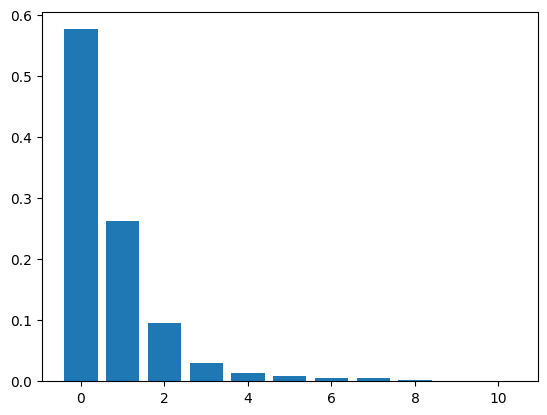

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

x_length = len(X_train[0])
x = np.arange(x_length)

import matplotlib.pyplot as plt 

plt.bar(x, pca.explained_variance_ratio_)
plt.show()

[3.18945037 1.64874246 1.13679087 0.92976403 0.86935845 0.77277981
 0.740632   0.67901989 0.56806921 0.47277042 0.25480814]
[0.28319995 0.14639631 0.10093874 0.08255627 0.07719269 0.06861721
 0.06576272 0.06029202 0.05044041 0.04197857 0.02262511]


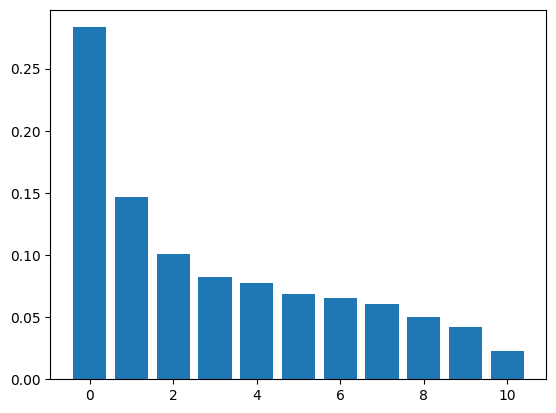

In [15]:
pca_std = PCA()
pca_std.fit(X_train_std)

print(pca_std.explained_variance_)
print(pca_std.explained_variance_ratio_)

plt.bar(x, pca_std.explained_variance_ratio_)
plt.show()

In [16]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_std_pca = pca_std.fit_transform(X_train_std)
X_test_std_pca = pca_std.transform(X_test_std)

c:\Users\sungc\CommunityAnalitics\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.49851964 0.09969297 0.07338899 0.05727278 0.05455974 0.04911528
 0.04637925 0.04273015 0.04087563 0.03359711 0.00386844]


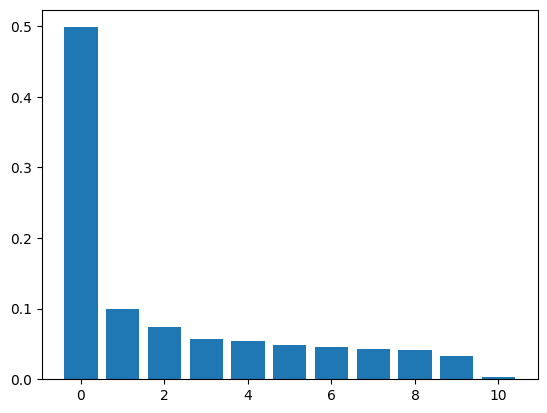

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print(lda.explained_variance_ratio_)

plt.bar(x, lda.explained_variance_ratio_)
plt.show()

c:\Users\sungc\CommunityAnalitics\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[9.93705647e-01 3.34249630e-03 8.86341877e-04 5.00968447e-04
 4.18585742e-04 3.03506024e-04 2.64732922e-04 2.24730037e-04
 1.84155815e-04 1.53313327e-04 1.55224042e-05]


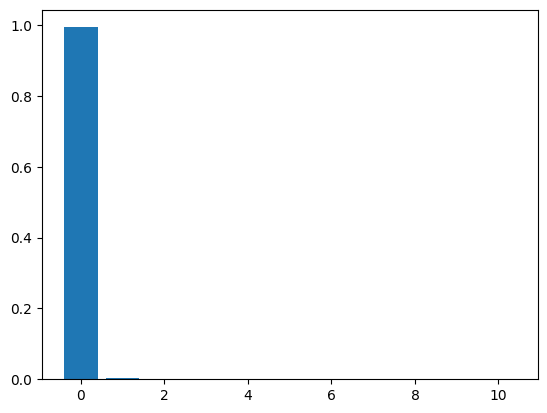

In [18]:
lda_std = LinearDiscriminantAnalysis()
lda_std.fit(X_train_std, y_train)
print(lda_std.explained_variance_ratio_)

plt.bar(x, lda_std.explained_variance_ratio_)
plt.show()

c:\Users\sungc\CommunityAnalitics\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.49851964 0.09969297 0.07338899 0.05727278 0.05455974 0.04911528
 0.04637925 0.04273015 0.04087563 0.03359711 0.00386844]


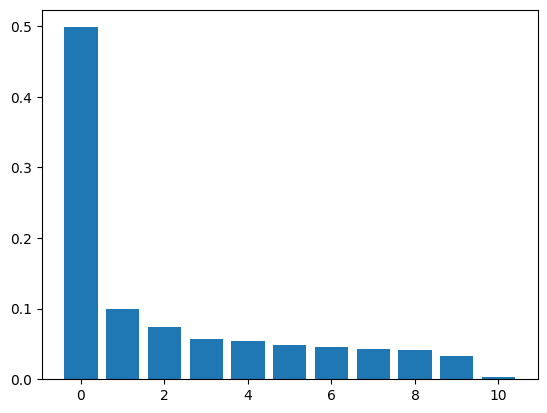

In [19]:
lda_pca = LinearDiscriminantAnalysis()
lda_pca.fit(X_train_pca, y_train)
print(lda_pca.explained_variance_ratio_)

plt.bar(x, lda_pca.explained_variance_ratio_)
plt.show()

c:\Users\sungc\CommunityAnalitics\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[9.93705647e-01 3.34249630e-03 8.86341877e-04 5.00968447e-04
 4.18585742e-04 3.03506024e-04 2.64732922e-04 2.24730037e-04
 1.84155815e-04 1.53313327e-04 1.55224042e-05]


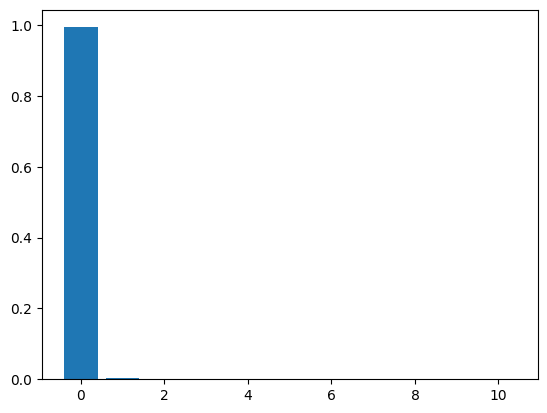

In [20]:
lda_std_pca = LinearDiscriminantAnalysis()
lda_std_pca.fit(X_train_std_pca, y_train)
print(lda_std_pca.explained_variance_ratio_)

plt.bar(x, lda_std_pca.explained_variance_ratio_)
plt.show()

In [28]:
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

X_train_std_lda = lda_std.transform(X_train_std)
X_test_std_lda = lda_std.transform(X_test_std)

X_train_pca_lda = lda_pca.transform(X_train_pca)
X_test_pca_lda = lda_pca.transform(X_test_pca)

X_train_std_pca_lda = lda_std_pca.transform(X_train_std_pca)
X_test_std_pca_lda = lda_std_pca.transform(X_test_std_pca)

In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

def modelingAndVisualizing(X_train, X_test, title):
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)

    print(title)
    print('학습 정확도 : ', round(train_score, 3))
    print('검증 정확도 : ', round(test_score, 3))
    print("평균 정확도", np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    
    plt.plot(range(100), y_test[:100], label='True')
    plt.plot(range(100), y_pred[:100], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()
    return knn

Original
학습 정확도 :  0.314
검증 정확도 :  -0.329
평균 정확도 -0.34329845123063807


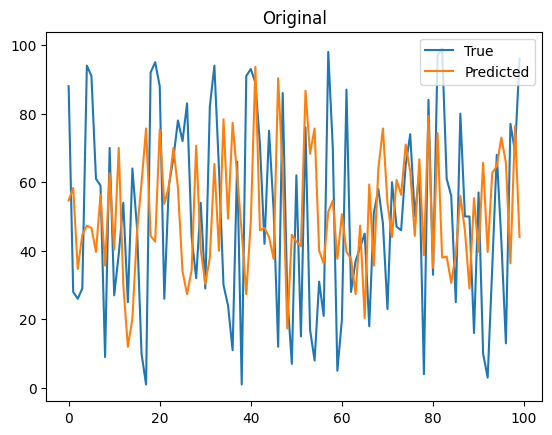

Standardized
학습 정확도 :  0.956
검증 정확도 :  -0.996
평균 정확도 -0.9424453841165507


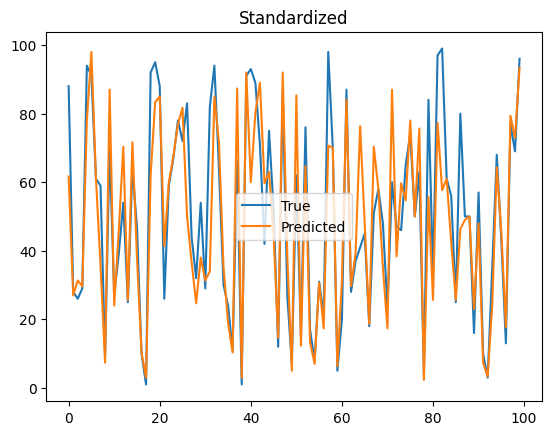

PCA
학습 정확도 :  0.314
검증 정확도 :  -0.329
평균 정확도 -0.3246772258517353


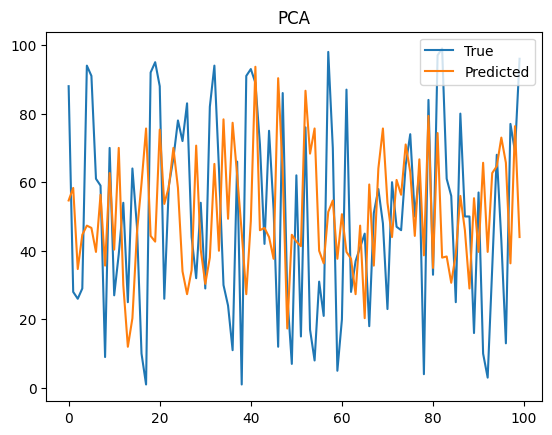

Standardized_PCA
학습 정확도 :  0.956
검증 정확도 :  -0.996
평균 정확도 -0.9424441765135182


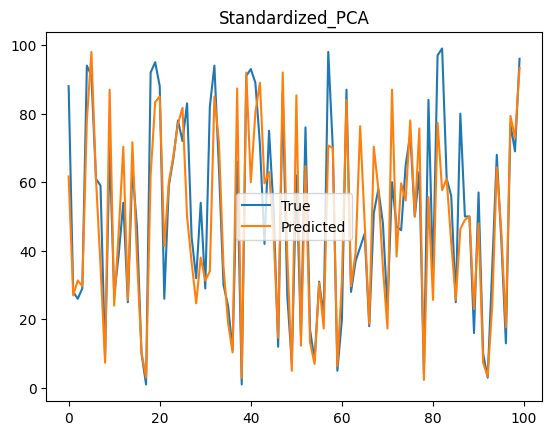

LDA
학습 정확도 :  0.315
검증 정확도 :  -0.322
평균 정확도 -0.34140529305229533


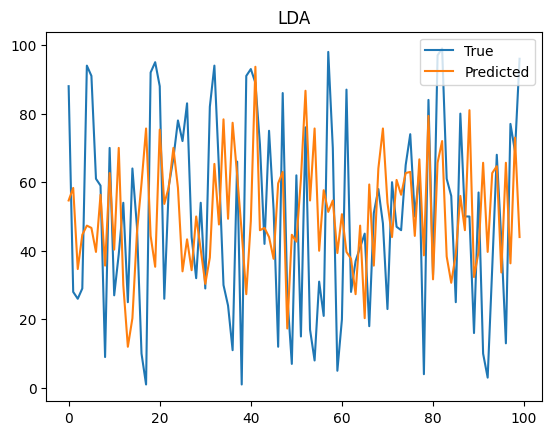

Standardized_LDA
학습 정확도 :  0.957
검증 정확도 :  -0.97
평균 정확도 -0.9475002376131887


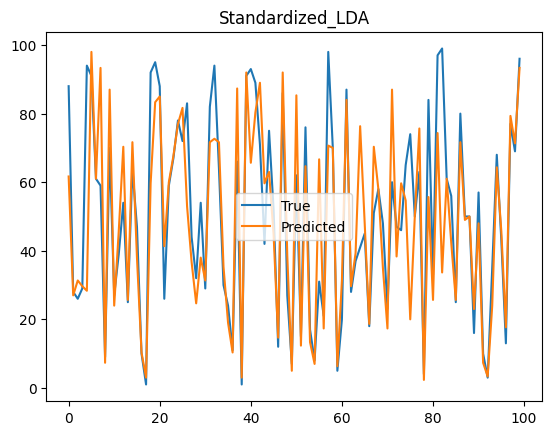

PCA_LDA
학습 정확도 :  0.314
검증 정확도 :  -0.322
평균 정확도 -0.32459230339177175


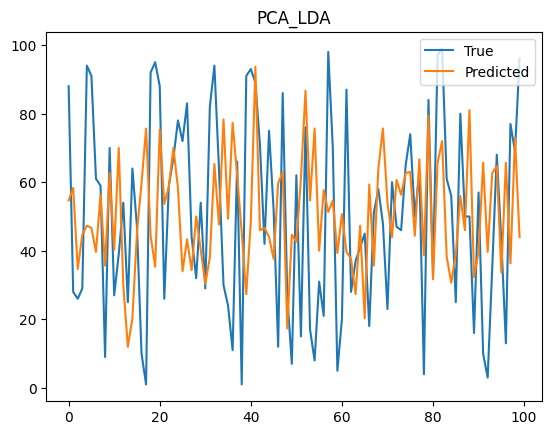

Standardized_PCA_LDA
학습 정확도 :  0.957
검증 정확도 :  -0.97
평균 정확도 -0.9475002376131887


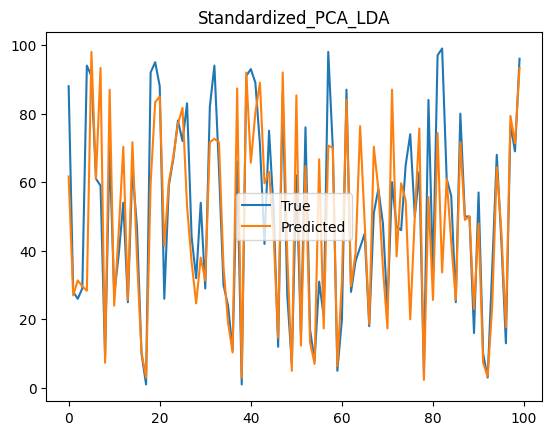

In [48]:
modelingList = [
    (X_train, X_test, 'Original'),
    (X_train_std, X_test_std, 'Standardized'),
    (X_train_pca, X_test_pca, 'PCA'),
    (X_train_std_pca, X_test_std_pca, 'Standardized_PCA'),
    (X_train_lda, X_test_lda, 'LDA'),
    (X_train_std_lda, X_test_std_lda, 'Standardized_LDA'),
    (X_train_pca_lda, X_test_pca_lda, 'PCA_LDA'),
    (X_train_std_pca_lda, X_test_std_pca_lda, 'Standardized_PCA_LDA')
]

import joblib
import os

for model in modelingList:
    knn = modelingAndVisualizing(*model)
    # save model to file
    if not os.path.exists('models'):
        os.makedirs('models')
        filePath = 'models/' + model[2] + '.pkl'
        joblib.dump(knn, filePath)
    

In [5]:


data2023 = pd.read_csv('data/dataframes/dataframe_2023to2023.csv', index_col=0)
label2023 = pd.read_csv('data/dataframes/label_2023to2023.csv', index_col=0)

In [6]:
data2023['date'] = data2023['date'] + 835
data2023

,date,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2023-01-01,835,12,206,574,1,106,333,0,31,173,414
2023-01-01,835,173,97,666,1,172,524,0,358,463,547
2023-01-01,835,300,74,652,1,91,527,0,21,430,113
2023-01-01,835,283,100,47,1,34,350,199,327,476,42
2023-01-01,835,240,50,49,1,43,514,0,41,466,322
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,887,187,381,100,1,247,223,0,317,404,416
2023-12-31,887,262,361,196,0,319,189,0,318,434,30
2023-12-31,887,92,331,273,1,38,311,22,158,240,393
2023-12-31,887,344,427,253,0,125,347,142,176,475,167


In [7]:
X2023, y2023 = create_sequences(2023, data2023, label2023)
X2023 = X2023.reshape(X2023.shape[0]*X2023.shape[1], X2023.shape[2])
y2023 = y2023.reshape(y2023.shape[0]*y2023.shape[1], 1)

In [21]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(X_train)
X2023_std = std.transform(X2023)

In [22]:
X2023_pca = pca.transform(X2023)
X2023_std_pca = pca_std.transform(X2023_std)
X2023_lda = lda.transform(X2023)
X2023_std_lda = lda_std.transform(X2023_std)
X2023_pca_lda = lda_pca.transform(X2023_pca)
X2023_std_pca_lda = lda_std_pca.transform(X2023_std_pca)

In [24]:
list2023 = [
    (X2023, 'Original'),
    (X2023_std, 'Standardized'),
    (X2023_pca, 'PCA'),
    (X2023_std_pca, 'Standardized_PCA'),
    (X2023_lda, 'LDA'),
    (X2023_std_lda, 'Standardized_LDA'),
    (X2023_pca_lda, 'PCA_LDA'),
    (X2023_std_pca_lda, 'Standardized_PCA_LDA')
]

import joblib

filePath = f'models/KNN_{list2023[0][1]}.pkl'
model = joblib.load(filePath)
print(list2023[0][1])

y_pred = model.predict(list2023[0][0])
print('정확도 : ', model.score(list2023[0][0], y2023))
plt.plot(range(100), y2023[:100], label='True')
plt.plot(range(100), y_pred[:100], label='Predicted')
plt.title(list2023[0][1])
plt.legend()
plt.show()

Original


AttributeError: 'NoneType' object has no attribute 'predict'

In [25]:
def modelingAndVisualizing2023(X_train, y_train, data, label, title):
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)
    pred = knn.predict(data)
    
    train_score = knn.score(X_train, y_train)

    print(title)
    print('학습 정확도 : ', round(train_score, 3))
    print("평균 예측 정확도", np.mean(cross_val_score(knn, data, label, cv=5)))
    
    plt.plot(range(100), label[:100], label='True 2023')
    plt.plot(range(100), pred[:100], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()
    return knn

In [29]:
listFor2023 = [
    (X_train, y_train, X2023, y2023, 'Original'),
    (X_train_std, y_train, X2023_std, y2023, 'Standardized'),
    (X_train_pca, y_train, X2023_pca, y2023, 'PCA'),
    (X_train_std_pca, y_train, X2023_std_pca, y2023, 'Standardized_PCA'),
    (X_train_lda, y_train, X2023_lda, y2023, 'LDA'),
    (X_train_std_lda, y_train, X2023_std_lda, y2023, 'Standardized_LDA'),
    (X_train_pca_lda, y_train, X2023_pca_lda, y2023, 'PCA_LDA'),
    (X_train_std_pca_lda, y_train, X2023_std_pca_lda, y2023, 'Standardized_PCA_LDA')
]

Original
학습 정확도 :  0.313
평균 예측 정확도 0.29202133048136647


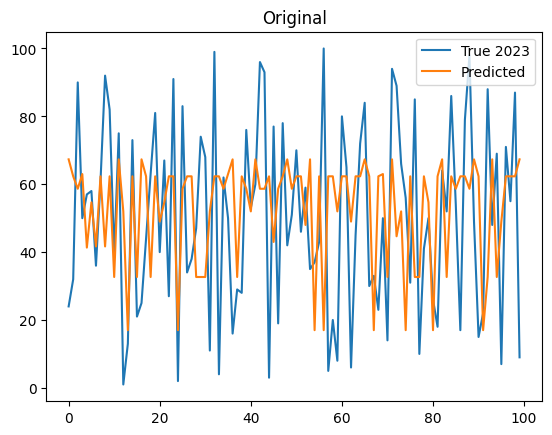

Standardized
학습 정확도 :  0.956
평균 예측 정확도 0.3286200304739844


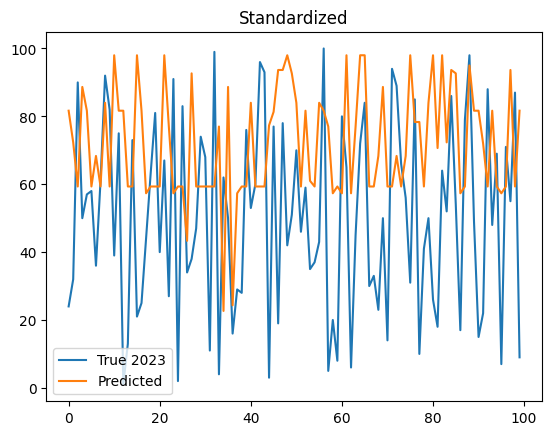

PCA
학습 정확도 :  0.313
평균 예측 정확도 0.2919965916026911


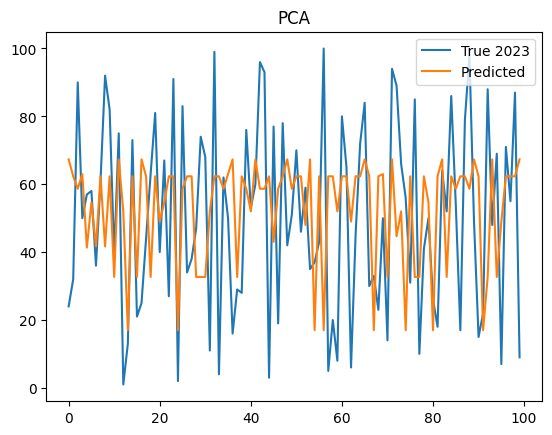

Standardized_PCA
학습 정확도 :  0.957
평균 예측 정확도 0.32953618579174204


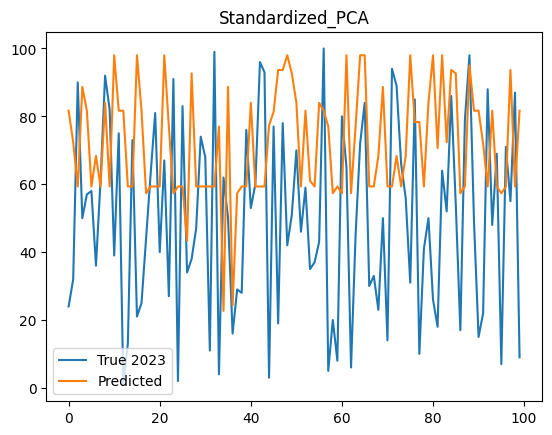

LDA
학습 정확도 :  0.313
평균 예측 정확도 0.35769769728085155


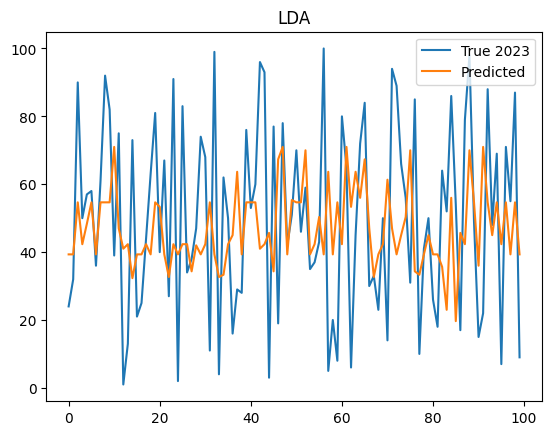

Standardized_LDA
학습 정확도 :  0.957
평균 예측 정확도 0.35947069033688156


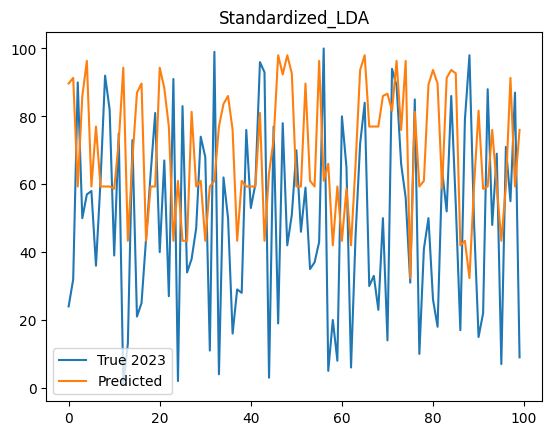

PCA_LDA
학습 정확도 :  0.313
평균 예측 정확도 0.35661955761535885


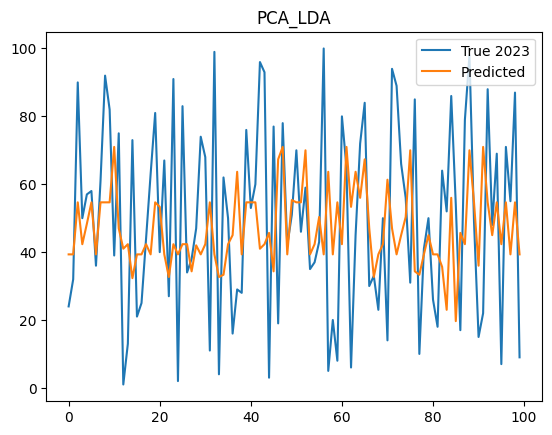

Standardized_PCA_LDA
학습 정확도 :  0.957
평균 예측 정확도 0.35909798066824283


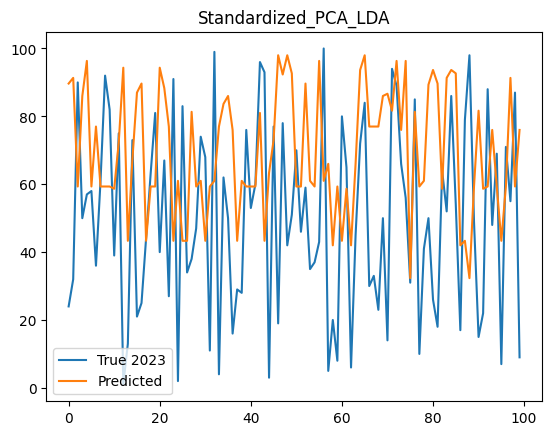

In [30]:
for model in listFor2023:
    modelingAndVisualizing2023(*model)

In [37]:
# GridSearchCV로 KNN의 최적 파라미터 찾기
# 최적 모델 선정 후 models/best_KNN.pkl로 저장
# 최적 모델로 2023년 데이터 예측 후 시각화

from sklearn.model_selection import GridSearchCV

def getBestKNN(X_train, X_test, title):
    knn = KNeighborsRegressor()
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    
    print(title)
    print('Best parameters : ', grid_search.best_params_)
    print('Best score : ', grid_search.best_score_)
    print('Best estimator test score : ', grid_search.best_estimator_.score(X_test, y_test))

    return grid_search.best_estimator_

knnList = [
    (X_train_std, X_test_std, 'Standardized'),
    (X_train_std_pca, X_test_std_pca, 'Standardized_PCA'),
    (X_train_std_lda, X_test_std_lda, 'Standardized_LDA'),
    (X_train_std_pca_lda, X_test_std_pca_lda, 'Standardized_PCA_LDA')
]

list2023 = [
    (X2023_std, 'Standardized'),
    (X2023_std_pca, 'Standardized_PCA'),
    (X2023_std_lda, 'Standardized_LDA'),
    (X2023_std_pca_lda, 'Standardized_PCA_LDA')
]

# modelingList의 데이터로 학습한 최적 모델로 list2023의 데이터들로 2023년 데이터 예측
def predict2023(model, data, label, title):
    pred = model.predict(data)
    
    print(title)
    print('정확도 : ', model.score(data, label))
    plt.plot(range(100), label[:100], label='True 2023')
    plt.plot(range(100), pred[:100], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()
    
for knn, model in zip(knnList, modelingList):
    bestModel = getBestKNN(*knn)
    predict2023(bestModel, model[0], y2023, model[1])